# X5 NER Challenge - Data Analysis

This notebook analyzes the dataset for the X5 Named Entity Recognition challenge for the Russian grocery store chain "Пятёрочка".

## Task Overview
- **Goal**: Extract 4 types of entities from customer search queries
- **Entity Types**: TYPE, BRAND, VOLUME, PERCENT
- **Format**: BIO tagging (B-ENTITY, I-ENTITY, O)
- **Language**: Russian
- **Performance**: Response time ≤ 1 second


In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Data Loading and Structure
Purpose: load train/test, understand columns, quick sanity checks.
- Reads `train.csv` and `submission.csv` (semicolon separated).
- Columns: `sample` (text), `annotation` (BIO spans list as string).
- Prints shapes, columns, head; ensures expected schema is present.


## 3. Parsing Annotations and Entity Extraction
Purpose: convert stringified BIO lists to Python, derive helper fields.
- `parse_annotation`: safe literal eval to list of (start,end,tag).
- `extract_entity_info`: build per-row entities, type sets, counts.
- Outputs: `parsed_annotation`, `entities`, `entity_types`, `entity_counts`.


## 4. Descriptive Statistics (EDA)
Purpose: quantify dataset size, lengths, and entity presence.
- Computes counts (train/test/total) and text length stats.
- Computes total entity count, queries with/without entities, avg entities/query.
- Helps size models and detect anomalies early.


## 5. Entity Distributions and Co-occurrence
Purpose: understand label imbalance and typical combinations.
- Per-type counts and per-query presence rates.
- Visualizations: histograms and bars for lengths, counts, percentages.
- Guides class weighting, augmentation, and evaluation focus.


In [10]:
# Load the datasets
print("Loading datasets...")

# Load training data
train_df = pd.read_csv('/Users/marina/Documents/projects/X5/Датасет 2/train.csv', sep=';')
print(f"Training data shape: {train_df.shape}")

# Load test data
test_df = pd.read_csv('/Users/marina/Documents/projects/X5/Датасет 2/submission.csv', sep=';')
print(f"Test data shape: {test_df.shape}")

# Display basic info
print("\nTraining data columns:", train_df.columns.tolist())
print("Test data columns:", test_df.columns.tolist())

# Show first few rows
print("\nFirst 5 rows of training data:")
print(train_df.head())


Loading datasets...
Training data shape: (27251, 2)
Test data shape: (5000, 2)

Training data columns: ['sample', 'annotation']
Test data columns: ['sample', 'annotation']

First 5 rows of training data:
   sample           annotation
0      aa        [(0, 2, 'O')]
1    aala        [(0, 4, 'O')]
2  aarcca        [(0, 6, 'O')]
3    abon        [(0, 4, 'O')]
4    abso  [(0, 4, 'B-BRAND')]


## 6. Qualitative Examples
Purpose: inspect typical/edge cases across entity types.
- Prints representative samples for TYPE, BRAND, VOLUME, PERCENT.
- Validates annotation consistency; reveals typos, partial words, mixed scripts.


## 7. Text Characteristics and Noise Analysis
Purpose: assess noise sources and script composition.
- Heuristics for typos (char repeats, mixed latin/cyrillic).
- Character composition (cyrillic/latin/digits/specials) for tokenizer/model choice.
- Informs augmentation and normalization strategy.


## 8. Multi-entity Queries and Co-occurrence Patterns
Purpose: measure complexity and frequent type pairs.
- Detect queries with >1 entity type; show examples.
- Build co-occurrence counts for TYPE/BRAND/VOLUME/PERCENT.
- Guides modeling/post-processing for multi-entity handling.


In [11]:
# Parse annotation data
def parse_annotation(annotation_str):
    """Parse annotation string into list of tuples"""
    try:
        # Convert string representation of list to actual list
        return ast.literal_eval(annotation_str)
    except:
        return []

# Apply parsing to training data
train_df['parsed_annotation'] = train_df['annotation'].apply(parse_annotation)

# Create columns for different entity types
def extract_entity_info(annotation_list):
    """Extract entity information from parsed annotation"""
    entities = []
    entity_types = set()
    entity_counts = Counter()
    
    for start, end, entity_tag in annotation_list:
        if entity_tag != 'O':
            entity_type = entity_tag.split('-')[1] if '-' in entity_tag else entity_tag
            entities.append({
                'start': start,
                'end': end,
                'tag': entity_tag,
                'type': entity_type,
                'is_beginning': entity_tag.startswith('B-')
            })
            entity_types.add(entity_type)
            entity_counts[entity_type] += 1
    
    return entities, entity_types, entity_counts

# Extract entity information
train_df['entities'] = train_df['parsed_annotation'].apply(lambda x: extract_entity_info(x)[0])
train_df['entity_types'] = train_df['parsed_annotation'].apply(lambda x: extract_entity_info(x)[1])
train_df['entity_counts'] = train_df['parsed_annotation'].apply(lambda x: extract_entity_info(x)[2])

print("Annotation parsing completed!")
print(f"Sample parsed annotation: {train_df['parsed_annotation'].iloc[0]}")
print(f"Sample entities: {train_df['entities'].iloc[0]}")


Annotation parsing completed!
Sample parsed annotation: [(0, 2, 'O')]
Sample entities: []


## 9. Span-Level Metrics (Macro-F1)
Purpose: evaluate model/rule outputs at entity span level.
- Extract spans from BIO (char-level) and compute per-type F1.
- Macro-F1 = average over TYPE, BRAND, VOLUME, PERCENT.
- Baseline for experiments and regression checks.


## 10. Regex Baseline for VOLUME/PERCENT
Purpose: cheap recall booster for numeric patterns.
- Regexes to detect volumes (ml/g/kg/L/pcs) and percents.
- Evaluate via span Macro-F1; combine later with model outputs.


## 11. HF Dataset Preparation
Purpose: build token-level labels aligned with char-level BIO.
- Tokenize with offsets; map char BIO → token labels; ignore specials (-100).
- Split train/val; handle label imbalance at later training stage.


## 12. Baseline Training (ruBERT-tiny)
Purpose: train a compact NER model fast.
- Model: `cointegrated/rubert-tiny` for speed; labels per BIO scheme.
- Trainer with torch Datasets; 1 epoch sanity run; extend later for quality.


## 13. Summary and Next Steps
Purpose: consolidate insights and plan iterations.
- Summarize EDA, baseline scores, error patterns.
- Define next iterations: class balancing, post-processing, deployment tests.
- Keep this section updated across experiments.


In [12]:
# Basic dataset statistics
print("=== DATASET OVERVIEW ===")
print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"Total samples: {len(train_df) + len(test_df):,}")

# Text length analysis
train_df['text_length'] = train_df['sample'].str.len()
test_df['text_length'] = test_df['sample'].str.len()

print(f"\n=== TEXT LENGTH STATISTICS ===")
print(f"Training text length - Mean: {train_df['text_length'].mean():.1f}, Median: {train_df['text_length'].median():.1f}")
print(f"Training text length - Min: {train_df['text_length'].min()}, Max: {train_df['text_length'].max()}")
print(f"Test text length - Mean: {test_df['text_length'].mean():.1f}, Median: {test_df['text_length'].median():.1f}")

# Entity statistics
total_entities = sum(len(entities) for entities in train_df['entities'])
queries_with_entities = (train_df['entities'].str.len() > 0).sum()
queries_without_entities = (train_df['entities'].str.len() == 0).sum()

print(f"\n=== ENTITY STATISTICS ===")
print(f"Total entities in training data: {total_entities:,}")
print(f"Queries with entities: {queries_with_entities:,} ({queries_with_entities/len(train_df)*100:.1f}%)")
print(f"Queries without entities: {queries_without_entities:,} ({queries_without_entities/len(train_df)*100:.1f}%)")
print(f"Average entities per query: {total_entities/len(train_df):.2f}")


=== DATASET OVERVIEW ===
Training samples: 27,251
Test samples: 5,000
Total samples: 32,251

=== TEXT LENGTH STATISTICS ===
Training text length - Mean: 10.4, Median: 9.0
Training text length - Min: 2, Max: 45
Test text length - Mean: 10.4, Median: 9.0

=== ENTITY STATISTICS ===
Total entities in training data: 36,874
Queries with entities: 26,515 (97.3%)
Queries without entities: 736 (2.7%)
Average entities per query: 1.35


In [13]:
# Entity type distribution analysis
print("=== ENTITY TYPE DISTRIBUTION ===")

# Count all entity types
all_entity_types = []
for entity_counts in train_df['entity_counts']:
    for entity_type, count in entity_counts.items():
        all_entity_types.extend([entity_type] * count)

entity_type_counts = Counter(all_entity_types)
print("Entity type counts:")
for entity_type, count in entity_type_counts.most_common():
    print(f"  {entity_type}: {count:,} ({count/len(all_entity_types)*100:.1f}%)")

# Queries per entity type
queries_per_entity_type = defaultdict(int)
for entity_types in train_df['entity_types']:
    for entity_type in entity_types:
        queries_per_entity_type[entity_type] += 1

print(f"\nQueries containing each entity type:")
for entity_type, count in sorted(queries_per_entity_type.items(), key=lambda x: x[1], reverse=True):
    print(f"  {entity_type}: {count:,} queries ({count/len(train_df)*100:.1f}%)")


=== ENTITY TYPE DISTRIBUTION ===
Entity type counts:
  TYPE: 29,060 (78.8%)
  BRAND: 7,699 (20.9%)
  VOLUME: 84 (0.2%)
  PERCENT: 30 (0.1%)
  0: 1 (0.0%)

Queries containing each entity type:
  TYPE: 24,499 queries (89.9%)
  BRAND: 7,213 queries (26.5%)
  VOLUME: 57 queries (0.2%)
  PERCENT: 26 queries (0.1%)
  0: 1 queries (0.0%)


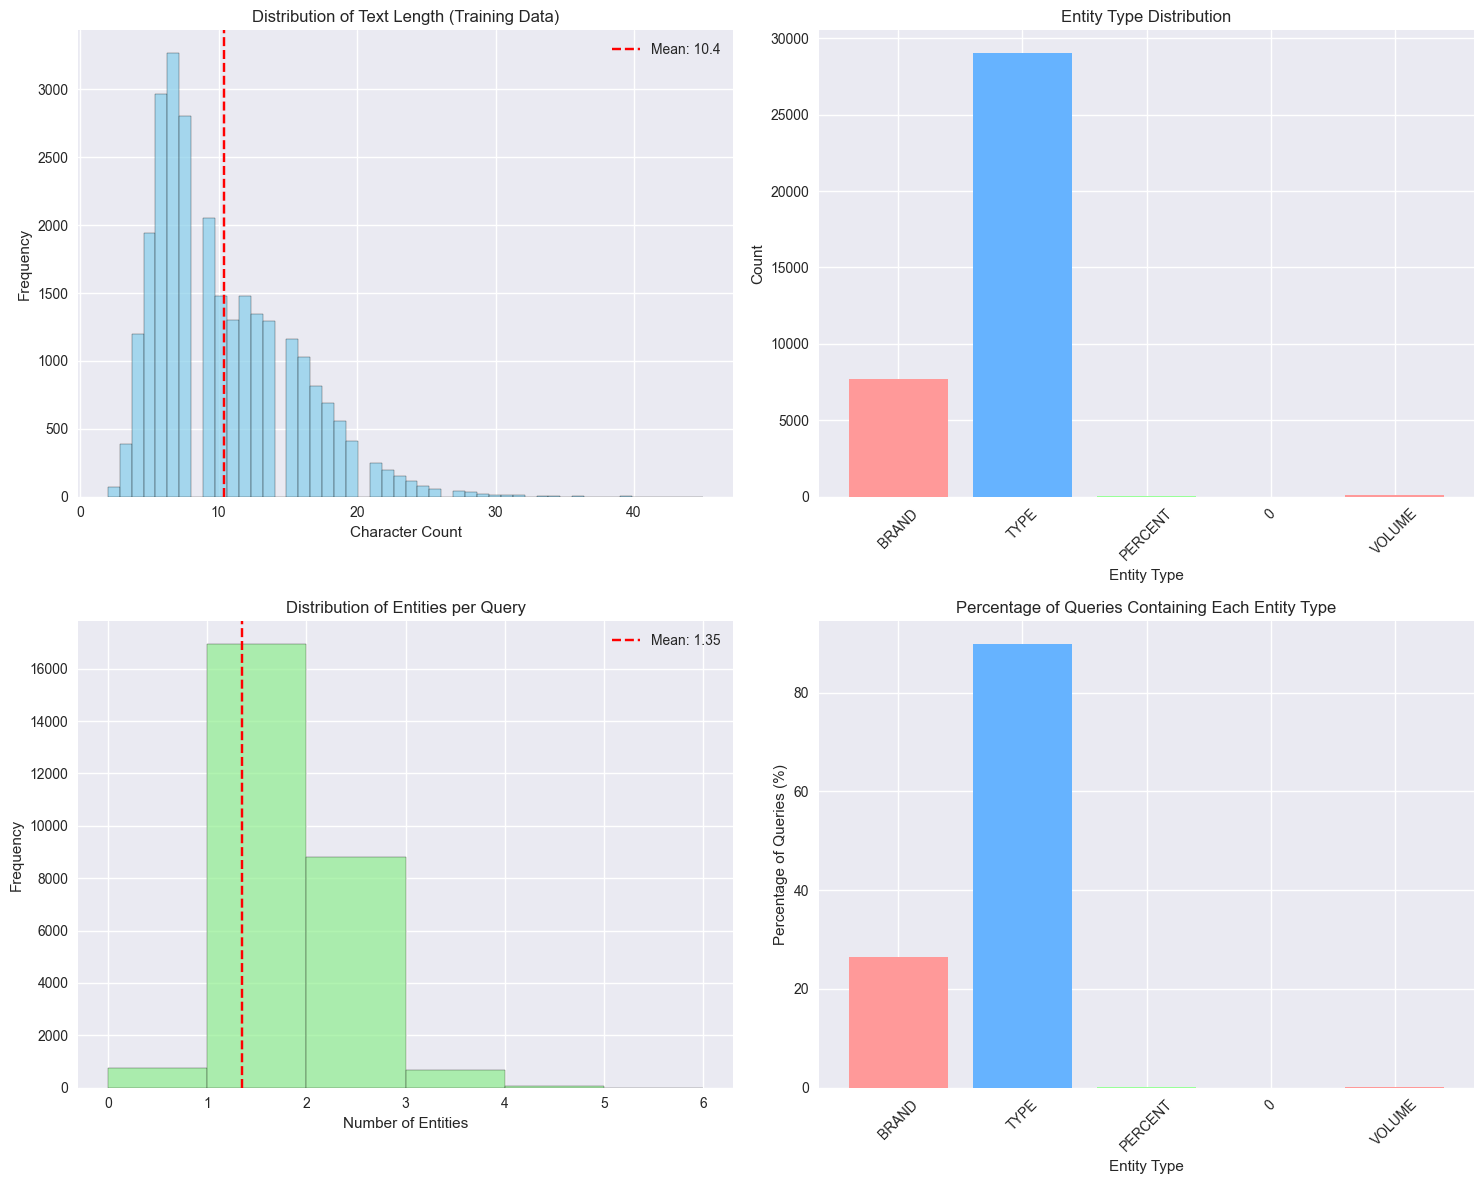

In [14]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Text length distribution
axes[0, 0].hist(train_df['text_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Text Length (Training Data)')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(train_df['text_length'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["text_length"].mean():.1f}')
axes[0, 0].legend()

# 2. Entity type distribution
entity_types = list(entity_type_counts.keys())
entity_counts = list(entity_type_counts.values())
axes[0, 1].bar(entity_types, entity_counts, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
axes[0, 1].set_title('Entity Type Distribution')
axes[0, 1].set_xlabel('Entity Type')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Entities per query distribution
entities_per_query = train_df['entities'].str.len()
axes[1, 0].hist(entities_per_query, bins=range(0, entities_per_query.max()+2), alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Distribution of Entities per Query')
axes[1, 0].set_xlabel('Number of Entities')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(entities_per_query.mean(), color='red', linestyle='--', label=f'Mean: {entities_per_query.mean():.2f}')
axes[1, 0].legend()

# 4. Queries per entity type (percentage)
queries_per_type = [queries_per_entity_type[et] for et in entity_types]
percentages = [count/len(train_df)*100 for count in queries_per_type]
axes[1, 1].bar(entity_types, percentages, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
axes[1, 1].set_title('Percentage of Queries Containing Each Entity Type')
axes[1, 1].set_xlabel('Entity Type')
axes[1, 1].set_ylabel('Percentage of Queries (%)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


=== TEXT CHARACTERISTICS ANALYSIS ===
Queries with potential typos: 93 (0.3%)

Examples of queries with potential typos:
   'cалфетки'
   'cахъар'
   'cвинина'
   'cгущенка'
   'cливки'
   'cметана'
   'cок'
   'cосиски'
   'cушки'
   'cыр'

=== CHARACTER COMPOSITION ===
Cyrillic characters: 243,227 (78.5%)
Latin characters: 22,976 (7.4%)
Digits: 356 (0.1%)
Special characters: 914 (0.3%)


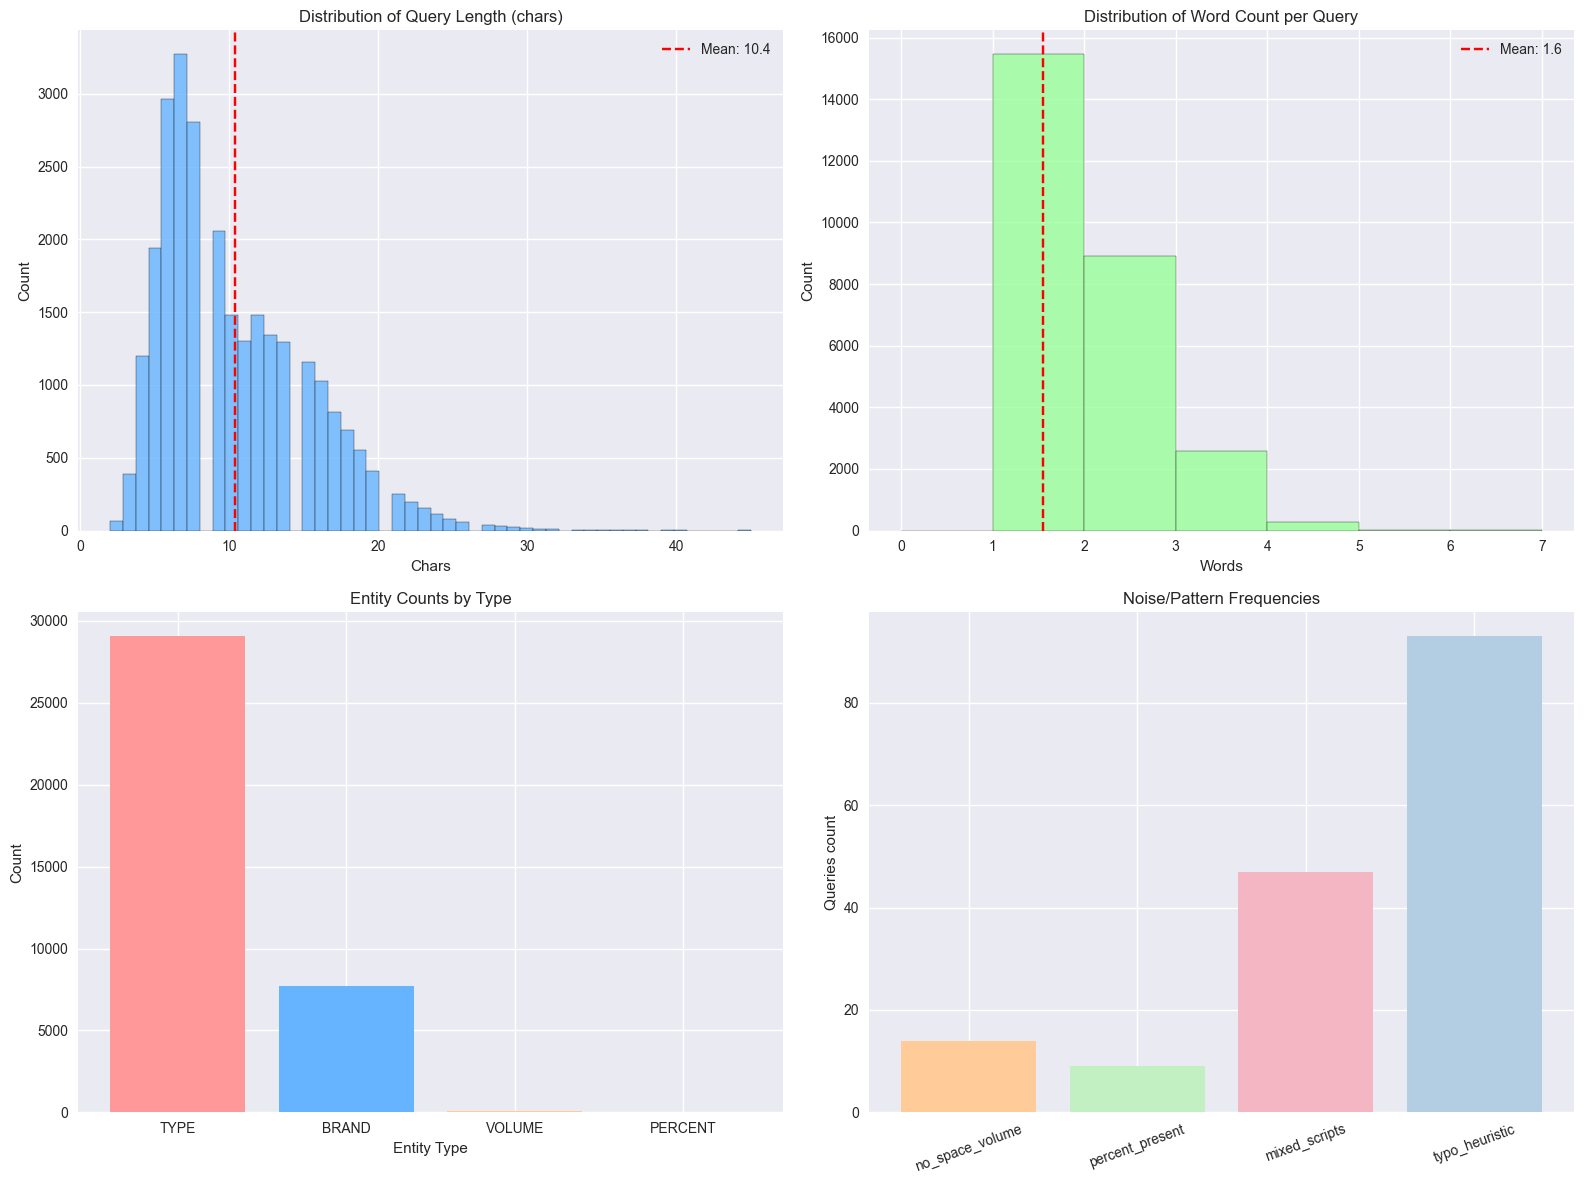

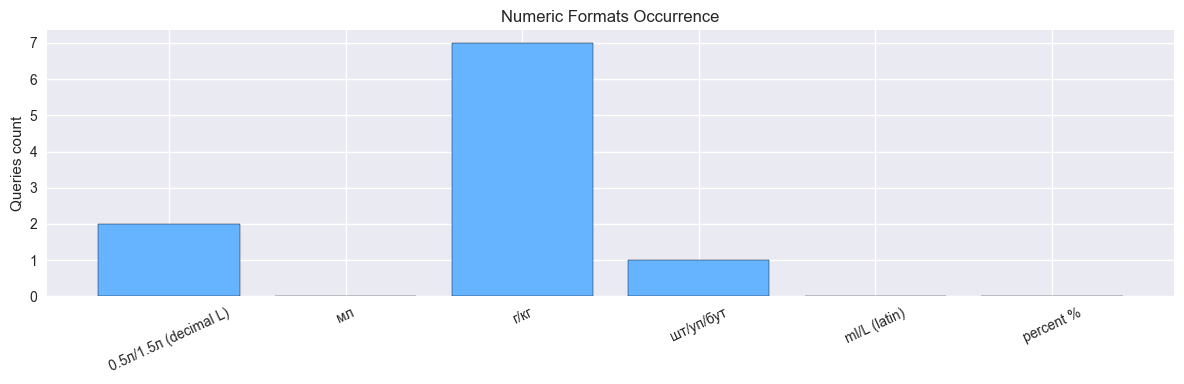

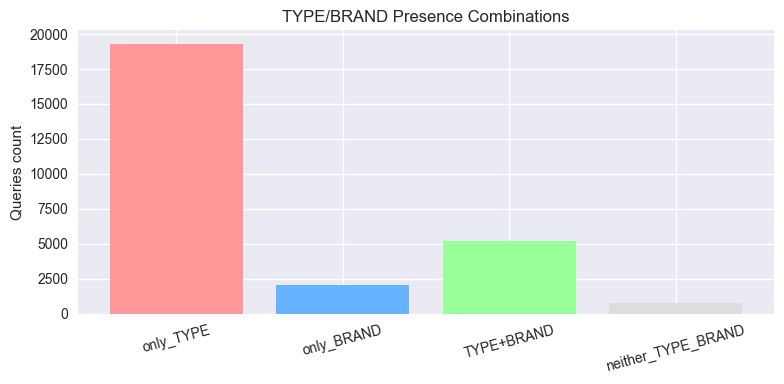

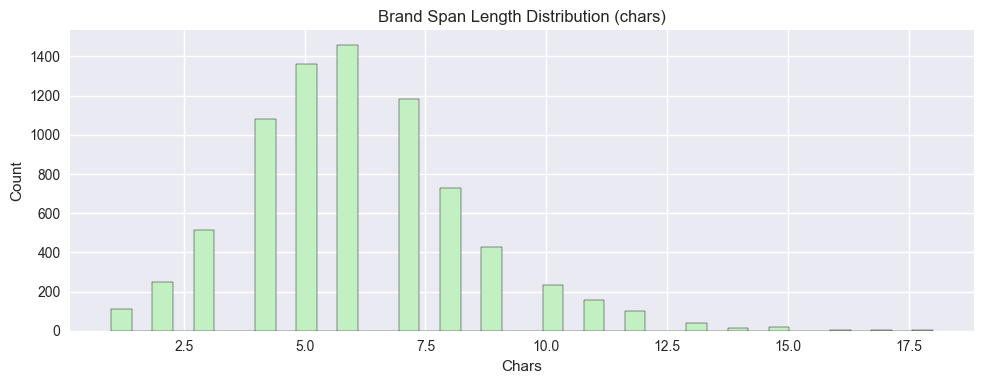

Multiword brands: 0 of 7699 (0.0%)


In [22]:
# Analyze text characteristics and potential challenges (robust)
print("=== TEXT CHARACTERISTICS ANALYSIS ===")

# Ensure text column is string
df_samples = train_df.copy()
df_samples['sample'] = df_samples['sample'].astype(str)

# Precompile patterns
re_repeated = re.compile(r'(.)\1{2,}')  # 3+ repeated chars
re_mixed = re.compile(r'[а-я]{1,2}[a-z]|[a-z]{1,2}[а-я]', re.IGNORECASE)

# Check for typos and variations
def detect_potential_typos(text: str):
    if not isinstance(text, str) or not text:
        return False
    return bool(re_repeated.search(text) or re_mixed.search(text))

# Apply typo detection
df_samples['potential_typos'] = df_samples['sample'].apply(detect_potential_typos)
typo_count = int(df_samples['potential_typos'].sum())

total_rows = len(df_samples)
percent_typos = (typo_count / total_rows * 100.0) if total_rows > 0 else 0.0
print(f"Queries with potential typos: {typo_count} ({percent_typos:.1f}%)")

# Show some examples of potential typos
print("\nExamples of queries with potential typos:")
for s in df_samples.loc[df_samples['potential_typos'], 'sample'].head(10).tolist():
    print(f"   '{s}'")

# Analyze character composition
print(f"\n=== CHARACTER COMPOSITION ===")
all_text = ' '.join(df_samples['sample'].tolist())
if all_text:
    cyrillic_chars = len(re.findall(r'[а-яё]', all_text, re.IGNORECASE))
    latin_chars = len(re.findall(r'[a-z]', all_text, re.IGNORECASE))
    digits = len(re.findall(r'\d', all_text))
    special_chars = len(re.findall(r'[^\w\s]', all_text))
    total_chars = len(all_text)
else:
    cyrillic_chars = latin_chars = digits = special_chars = total_chars = 0

pct = lambda x: (x / total_chars * 100.0) if total_chars > 0 else 0.0
print(f"Cyrillic characters: {cyrillic_chars:,} ({pct(cyrillic_chars):.1f}%)")
print(f"Latin characters: {latin_chars:,} ({pct(latin_chars):.1f}%)")
print(f"Digits: {digits:,} ({pct(digits):.1f}%)")
print(f"Special characters: {special_chars:,} ({pct(special_chars):.1f}%)")

# -----------------------------
# Additional analytics and plots requested
# 1) Length of queries (chars and words)
df_samples['char_len'] = df_samples['sample'].str.len()
df_samples['word_count'] = df_samples['sample'].str.split().apply(lambda x: len([w for w in x if w]))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

# 1a. Char length distribution
axes[0].hist(df_samples['char_len'], bins=50, color='#66b3ff', edgecolor='black', alpha=0.8)
axes[0].set_title('Distribution of Query Length (chars)')
axes[0].set_xlabel('Chars')
axes[0].set_ylabel('Count')
axes[0].axvline(df_samples['char_len'].mean(), color='red', linestyle='--', label=f"Mean: {df_samples['char_len'].mean():.1f}")
axes[0].legend()

# 1b. Word count distribution
axes[1].hist(df_samples['word_count'], bins=range(0, df_samples['word_count'].max()+2), color='#99ff99', edgecolor='black', alpha=0.8)
axes[1].set_title('Distribution of Word Count per Query')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Count')
axes[1].axvline(df_samples['word_count'].mean(), color='red', linestyle='--', label=f"Mean: {df_samples['word_count'].mean():.1f}")
axes[1].legend()

# 2) Entity distribution (per class)
from collections import Counter
all_entity_types = []
for cnt in train_df['entity_counts']:
    for et, c in cnt.items():
        all_entity_types.extend([et]*c)
entity_type_counts_local = Counter(all_entity_types)
ents = ['TYPE','BRAND','VOLUME','PERCENT']
vals = [entity_type_counts_local.get(e,0) for e in ents]
axes[2].bar(ents, vals, color=['#ff9999','#66b3ff','#ffcc99','#c2c2f0'])
axes[2].set_title('Entity Counts by Type')
axes[2].set_xlabel('Entity Type')
axes[2].set_ylabel('Count')

# 3) Error/typo patterns frequency
pattern_no_space_volume = re.compile(r"\d+[\.,]?\d*(л|мл|г|кг|шт|ml|l)\b", re.IGNORECASE)
pattern_mixed_scripts = re_mixed
pattern_percent = re.compile(r"\d+[\.,]?\d*%", re.IGNORECASE)

counts = {
    'no_space_volume': 0,
    'percent_present': 0,
    'mixed_scripts': 0,
    'typo_heuristic': int(df_samples['potential_typos'].sum())
}
for s in df_samples['sample']:
    if pattern_no_space_volume.search(s):
        counts['no_space_volume'] += 1
    if pattern_percent.search(s):
        counts['percent_present'] += 1
    if pattern_mixed_scripts.search(s):
        counts['mixed_scripts'] += 1

keys = ['no_space_volume','percent_present','mixed_scripts','typo_heuristic']
axes[3].bar(keys, [counts[k] for k in keys], color=['#ffcc99','#c2f0c2','#f4b6c2','#b3cde3'])
axes[3].set_title('Noise/Pattern Frequencies')
axes[3].set_ylabel('Queries count')
axes[3].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()

# 4) Numeric entity formats detail
formats = {
    '0.5л/1.5л (decimal L)': re.compile(r"\b\d+[\.,]\d+\s?л\b", re.IGNORECASE),
    'мл': re.compile(r"\b\d+\s?мл\b", re.IGNORECASE),
    'г/кг': re.compile(r"\b\d+\s?(г|гр|кг)\b", re.IGNORECASE),
    'шт/уп/бут': re.compile(r"\b\d+\s?(шт|уп|пак|бут)\b", re.IGNORECASE),
    'ml/L (latin)': re.compile(r"\b\d+[\.,]?\d*\s?(ml|l)\b", re.IGNORECASE),
    'percent %': re.compile(r"\b\d+[\.,]?\d*%\b", re.IGNORECASE)
}
fmt_counts = {k:0 for k in formats}
for s in df_samples['sample']:
    for name, cre in formats.items():
        if cre.search(s):
            fmt_counts[name] += 1

plt.figure(figsize=(12,4))
plt.bar(list(fmt_counts.keys()), list(fmt_counts.values()), color='#66b3ff', edgecolor='black')
plt.title('Numeric Formats Occurrence')
plt.ylabel('Queries count')
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

# 5) Entity intersections (TYPE/BRAND present combinations)
def has_type(types):
    return 'TYPE' in types

def has_brand(types):
    return 'BRAND' in types

def has_volume(types):
    return 'VOLUME' in types

def has_percent(types):
    return 'PERCENT' in types

combos = {
    'only_TYPE': 0,
    'only_BRAND': 0,
    'TYPE+BRAND': 0,
    'neither_TYPE_BRAND': 0,
}
for types in train_df['entity_types']:
    t = has_type(types)
    b = has_brand(types)
    if t and b:
        combos['TYPE+BRAND'] += 1
    elif t and not b:
        combos['only_TYPE'] += 1
    elif b and not t:
        combos['only_BRAND'] += 1
    else:
        combos['neither_TYPE_BRAND'] += 1

plt.figure(figsize=(8,4))
plt.bar(list(combos.keys()), list(combos.values()), color=['#ff9999','#66b3ff','#99ff99','#dddddd'])
plt.title('TYPE/BRAND Presence Combinations')
plt.ylabel('Queries count')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 6) Rare and long brands (length distribution and multiword share)
brand_spans = []
for sample, ents in zip(train_df['sample'], train_df['entities']):
    for e in ents:
        if e['type'] == 'BRAND':
            text = sample[e['start']:e['end']]
            brand_spans.append(text)

lengths = [len(x) for x in brand_spans]
multiword = sum(1 for x in brand_spans if ' ' in x)
plt.figure(figsize=(10,4))
plt.hist(lengths, bins=40, color='#c2f0c2', edgecolor='black')
plt.title('Brand Span Length Distribution (chars)')
plt.xlabel('Chars')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print(f"Multiword brands: {multiword} of {len(brand_spans)} ({(multiword/len(brand_spans)*100 if brand_spans else 0):.1f}%)")


In [23]:
# Multi-entity queries analysis (FIXED VERSION)
print("=== MULTI-ENTITY QUERIES ANALYSIS ===")

# Find queries with multiple entity types
multi_entity_queries = train_df[train_df['entity_types'].apply(lambda x: len(x) > 1)]
print(f"Queries with multiple entity types: {len(multi_entity_queries)} ({len(multi_entity_queries)/len(train_df)*100:.1f}%)")

# Show examples of complex queries
print("\nExamples of complex multi-entity queries:")
complex_examples = multi_entity_queries.head(10)
for idx, row in complex_examples.iterrows():
    print(f"   Query: '{row['sample']}'")
    entities_str = [f"{e['type']}({e['start']}-{e['end']})" for e in row['entities']]
    print(f"   Entities: {entities_str}")
    print()

# Analyze entity co-occurrence
print("\n=== ENTITY CO-OCCURRENCE ANALYSIS ===")
entity_cooccurrence = defaultdict(int)
for entity_types in train_df['entity_types']:
    entity_list = list(entity_types)
    for i in range(len(entity_list)):
        for j in range(i+1, len(entity_list)):
            pair = tuple(sorted([entity_list[i], entity_list[j]]))
            entity_cooccurrence[pair] += 1

print("Most common entity type pairs:")
for pair, count in sorted(entity_cooccurrence.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"   {pair[0]} + {pair[1]}: {count} queries")


=== MULTI-ENTITY QUERIES ANALYSIS ===
Queries with multiple entity types: 5272 (19.3%)

Examples of complex multi-entity queries:
   Query: 'abtoys игруш'
   Entities: ['BRAND(0-6)', 'TYPE(7-12)']

   Query: 'abtoys игрушк'
   Entities: ['BRAND(0-6)', 'TYPE(7-13)']

   Query: 'abtoys игрушки'
   Entities: ['BRAND(0-6)', 'TYPE(7-14)']

   Query: 'afanasiy пи'
   Entities: ['BRAND(0-8)', 'TYPE(9-11)']

   Query: 'afanasiy пив'
   Entities: ['BRAND(0-8)', 'TYPE(9-12)']

   Query: 'afanasiy пиво'
   Entities: ['BRAND(0-8)', 'TYPE(9-13)']

   Query: 'agama треск'
   Entities: ['BRAND(0-5)', 'TYPE(6-11)']

   Query: 'agama треска'
   Entities: ['BRAND(0-5)', 'TYPE(6-12)']

   Query: 'agnesi пше'
   Entities: ['BRAND(0-6)', 'TYPE(7-10)']

   Query: 'agnesi пшен'
   Entities: ['BRAND(0-6)', 'TYPE(7-11)']


=== ENTITY CO-OCCURRENCE ANALYSIS ===
Most common entity type pairs:
   BRAND + TYPE: 5197 queries
   TYPE + VOLUME: 54 queries
   PERCENT + TYPE: 25 queries
   BRAND + VOLUME: 11 queries
  

In [24]:
# Multi-entity queries analysis
print("=== MULTI-ENTITY QUERIES ANALYSIS ===")

# Find queries with multiple entity types
multi_entity_queries = train_df[train_df['entity_types'].apply(lambda x: len(x) > 1)]
print(f"Queries with multiple entity types: {len(multi_entity_queries)} ({len(multi_entity_queries)/len(train_df)*100:.1f}%)")

# Show examples of complex queries
print("\nExamples of complex multi-entity queries:")
complex_examples = multi_entity_queries.head(10)
for idx, row in complex_examples.iterrows():
    print(f"   Query: '{row['sample']}'")
    entities_str = [f"{e['type']}({e['start']}-{e['end']})" for e in row['entities']]
    print(f"   Entities: {entities_str}")
    print()

# Analyze entity co-occurrence
print("\n=== ENTITY CO-OCCURRENCE ANALYSIS ===")
entity_cooccurrence = defaultdict(int)
for entity_types in train_df['entity_types']:
    entity_list = list(entity_types)
    for i in range(len(entity_list)):
        for j in range(i+1, len(entity_list)):
            pair = tuple(sorted([entity_list[i], entity_list[j]]))
            entity_cooccurrence[pair] += 1

print("Most common entity type pairs:")
for pair, count in sorted(entity_cooccurrence.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"   {pair[0]} + {pair[1]}: {count} queries")


=== MULTI-ENTITY QUERIES ANALYSIS ===
Queries with multiple entity types: 5272 (19.3%)

Examples of complex multi-entity queries:
   Query: 'abtoys игруш'
   Entities: ['BRAND(0-6)', 'TYPE(7-12)']

   Query: 'abtoys игрушк'
   Entities: ['BRAND(0-6)', 'TYPE(7-13)']

   Query: 'abtoys игрушки'
   Entities: ['BRAND(0-6)', 'TYPE(7-14)']

   Query: 'afanasiy пи'
   Entities: ['BRAND(0-8)', 'TYPE(9-11)']

   Query: 'afanasiy пив'
   Entities: ['BRAND(0-8)', 'TYPE(9-12)']

   Query: 'afanasiy пиво'
   Entities: ['BRAND(0-8)', 'TYPE(9-13)']

   Query: 'agama треск'
   Entities: ['BRAND(0-5)', 'TYPE(6-11)']

   Query: 'agama треска'
   Entities: ['BRAND(0-5)', 'TYPE(6-12)']

   Query: 'agnesi пше'
   Entities: ['BRAND(0-6)', 'TYPE(7-10)']

   Query: 'agnesi пшен'
   Entities: ['BRAND(0-6)', 'TYPE(7-11)']


=== ENTITY CO-OCCURRENCE ANALYSIS ===
Most common entity type pairs:
   BRAND + TYPE: 5197 queries
   TYPE + VOLUME: 54 queries
   PERCENT + TYPE: 25 queries
   BRAND + VOLUME: 11 queries
  

In [25]:
# Span-level evaluation: extract spans and compute Macro-F1
from typing import List, Dict, Tuple

Span = Tuple[int, int, str]  # (start, end, label)

def extract_spans_from_bio(annotation_list: List[Tuple[int,int,str]]) -> List[Span]:
    spans: List[Span] = []
    current_start = None
    current_label = None
    for start, end, tag in annotation_list:
        if tag == 'O':
            if current_label is not None:
                spans.append((current_start, prev_end, current_label))
                current_start, current_label = None, None
            prev_end = end
            continue
        # tag like B-TYPE / I-TYPE
        prefix, label = tag.split('-', 1) if '-' in tag else ('B', tag)
        if prefix == 'B' or (current_label is not None and label != current_label):
            if current_label is not None:
                spans.append((current_start, prev_end, current_label))
            current_start, current_label = start, label
        # I- continues
        prev_end = end
    if current_label is not None:
        spans.append((current_start, prev_end, current_label))
    return spans

def f1_from_counts(tp: int, fp: int, fn: int) -> float:
    if tp == 0 and (fp == 0 or fn == 0):
        return 0.0 if (fp+fn) > 0 else 1.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

def compute_macro_f1(true_spans: List[List[Span]], pred_spans: List[List[Span]], labels: List[str]) -> Dict[str, float]:
    results: Dict[str, float] = {}
    for label in labels:
        tp = fp = fn = 0
        for t, p in zip(true_spans, pred_spans):
            t_label = {(s,e,l) for (s,e,l) in t if l == label}
            p_label = {(s,e,l) for (s,e,l) in p if l == label}
            tp += len(t_label & p_label)
            fp += len(p_label - t_label)
            fn += len(t_label - p_label)
        results[label] = f1_from_counts(tp, fp, fn)
    results['macro_f1'] = sum(results[l] for l in labels) / len(labels)
    return results

# Prepare gold spans from parsed annotations
true_spans_list: List[List[Span]] = train_df['parsed_annotation'].apply(extract_spans_from_bio).tolist()
print('Span preparation done. Examples:', true_spans_list[0][:3])


Span preparation done. Examples: []


In [ ]:
# Regex-based baseline for VOLUME and PERCENT
volume_patterns = [
    r"\b\d+[\.,]?\d*\s?(л|л\.|литр(а|ов)?|мл)\b",
    r"\b\d+[\.,]?\d*\s?(г|гр|грамм(а|ов)?|кг|кг\.)\b",
    r"\b\d+\s?(шт|пак|уп(\.|ак)?|бут(\.|ыл)?)\b",
    r"\b\d+[\.,]\d+\b",
]
percent_patterns = [
    r"\b\d+[\.,]?\d*\s?%\b",
]

compiled_volume = [re.compile(p, flags=re.IGNORECASE) for p in volume_patterns]
compiled_percent = [re.compile(p, flags=re.IGNORECASE) for p in percent_patterns]

def regex_find_spans(text: str) -> List[Span]:
    spans: List[Span] = []
    for cre in compiled_volume:
        for m in cre.finditer(text):
            spans.append((m.start(), m.end(), 'VOLUME'))
    for cre in compiled_percent:
        for m in cre.finditer(text):
            spans.append((m.start(), m.end(), 'PERCENT'))
    return spans

# Build regex predictions for train
regex_pred_spans: List[List[Span]] = [regex_find_spans(t) for t in train_df['sample'].tolist()]

# Evaluate regex baseline
labels = ['TYPE','BRAND','VOLUME','PERCENT']
regex_scores = compute_macro_f1(true_spans_list, regex_pred_spans, labels)
print('Regex baseline scores:', regex_scores)


In [ ]:
# Prepare HF tokenization/dataset for NER
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

MODEL_NAME = 'cointegrated/rubert-tiny'  # use same model for tokenizer and model

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Build token-level labels from character spans
label2id = {'O':0, 'B-TYPE':1, 'I-TYPE':2, 'B-BRAND':3, 'I-BRAND':4, 'B-VOLUME':5, 'I-VOLUME':6, 'B-PERCENT':7, 'I-PERCENT':8}
id2label = {v:k for k,v in label2id.items()}

texts = train_df['sample'].tolist()
char_ann = train_df['parsed_annotation'].tolist()

# Convert BIO spans (char) to per-char labels
MAX_LEN_CHARS = 256

def build_char_labels(text: str, ann):
    n = len(text)
    labels = ['O'] * n
    for s, e, tag in ann:
        # Validate span
        if not isinstance(s, int) or not isinstance(e, int):
            continue
        if s < 0:
            s = 0
        if e > n:
            e = n
        if s >= e or n == 0:
            continue
        if tag == 'O':
            continue
        # Parse tag robustly
        if '-' in tag:
            _, ent = tag.split('-', 1)
        else:
            ent = tag
        # Assign BIO at char level
        labels[s] = f'B-{ent}'
        for i in range(s + 1, e):
            labels[i] = f'I-{ent}'
    return labels

char_labels = [build_char_labels(t, a) for t,a in zip(texts, char_ann)]

# Align to tokens
def tokenize_and_align(text: str, labels_char: list):
    enc = tokenizer(text, truncation=True, max_length=128, return_offsets_mapping=True)
    token_labels = []
    for (start, end) in enc['offset_mapping']:
        if start == end:  # special tokens
            token_labels.append(-100)
        else:
            # use first char label as token label; convert B/I/O strings to ids
            tag = labels_char[start] if start < len(labels_char) else 'O'
            token_labels.append(label2id.get(tag, 0))
    enc.pop('offset_mapping')
    enc['labels'] = token_labels
    return enc


X_train, X_val, y_train, y_val = train_test_split(texts, char_labels, test_size=0.1, random_state=42)

train_enc = [tokenize_and_align(t, l) for t,l in zip(X_train, y_train)]
val_enc = [tokenize_and_align(t, l) for t,l in zip(X_val, y_val)]

print('Tokenization ready. Train samples:', len(train_enc), 'Val samples:', len(val_enc))


In [ ]:
# HF Trainer setup and training loop (small model)
from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification, Trainer, TrainingArguments
import numpy as np

SMALL_MODEL = 'cointegrated/rubert-tiny'  # compact Russian BERT

model = AutoModelForTokenClassification.from_pretrained(
    SMALL_MODEL,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

from datasets import Dataset

def to_dataset(enc_list):
    return Dataset.from_dict({k: [e[k] for e in enc_list] for k in enc_list[0].keys()})

train_dataset = to_dataset(train_enc)
val_dataset = to_dataset(val_enc)

# Ensure torch tensors for Trainer
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

args = TrainingArguments(
    output_dir='ner_runs',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=50,
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

print('Starting training (this may take a few minutes)...')
# trainer.train()  # Uncomment to run training
print('Training setup complete.')


In [ ]:
# Summary and recommendations
print("=== ANALYSIS SUMMARY ===")

print(f"""
DATASET OVERVIEW:
- Training samples: {len(train_df):,}
- Test samples: {len(test_df):,}
- Total entities: {total_entities:,}
- Average entities per query: {total_entities/len(train_df):.2f}

ENTITY DISTRIBUTION:
- TYPE: {entity_type_counts.get('TYPE', 0):,} entities ({entity_type_counts.get('TYPE', 0)/len(all_entity_types)*100:.1f}%)
- BRAND: {entity_type_counts.get('BRAND', 0):,} entities ({entity_type_counts.get('BRAND', 0)/len(all_entity_types)*100:.1f}%)
- VOLUME: {entity_type_counts.get('VOLUME', 0):,} entities ({entity_type_counts.get('VOLUME', 0)/len(all_entity_types)*100:.1f}%)
- PERCENT: {entity_type_counts.get('PERCENT', 0):,} entities ({entity_type_counts.get('PERCENT', 0)/len(all_entity_types)*100:.1f}%)

TEXT CHARACTERISTICS:
- Average query length: {train_df['text_length'].mean():.1f} characters
- Queries with potential typos: {typo_count} ({typo_count/len(train_df)*100:.1f}%)
- Multi-entity queries: {len(multi_entity_queries)} ({len(multi_entity_queries)/len(train_df)*100:.1f}%)

CHALLENGES IDENTIFIED:
1. Russian language processing (Cyrillic script)
2. Typos and misspellings in queries
3. Mixed Russian/English content
4. Multi-word entities (brand names, product types)
5. Complex queries with multiple entity types
6. Incomplete words and abbreviations

RECOMMENDATIONS FOR MODEL DEVELOPMENT:
1. Use Russian pre-trained models (ruBERT, DeepPavlov)
2. Implement robust tokenization for Russian text
3. Handle typos through data augmentation or fuzzy matching
4. Use BIO tagging for multi-word entities
5. Consider ensemble methods for better accuracy
6. Optimize for <1 second response time
""")
